<a href="https://colab.research.google.com/github/v2rinku/Lab-1-Quantum-Algorithm/blob/main/Bernstein_Vazirani_Algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Bernstein-Vazirani Algorithm

#### Written by Abraham Asfaw, IBM TJ Watson Research Center

 Bernstein-Vazirani algorithm. Briefly, the Bernstein-Vazirani algorithm allows us to determine a secret number stored inside a box. Mathematically, the problem statement that we are solving is the following:

Consider a hidden Boolean function $f$ which takes in a string of $n$ bits $\{x_0, x_1, \ldots x_{n-1}\}$ and returns 1 for only a unique n-bit string $s = \{s_0, s_1, \ldots s_{n-1}\}$ and 0 otherwise.

How many attempts do we need to make in order to find the secret number $s$?

Classically, we covered two approaches.

For an **n-bit secret number**, the first approach is to try all possible numbers from 0 to $2^n-1$. **This leads to an exponential number of attempts as $n$ grows.**

The second approach assumes that if the box isn't just giving a yes/no result if the number matches, but instead computes $s.x$ modulo 2, (this is a yes/no result as well, but we are now computing the bitwise AND between the two numbers $s$ and $x$, and adding up the results, and finally returning the sum modulo 2) then we can be a bit more clever and give the box $n$ different inputs (namely $2^0, 2^1, 2^2, \ldots, 2^{n-1}$) to reveal each of its bits. Check out the video to see how this works. **This method means that we would need to make $n$ attempts to find the secret number.**

**The Bernstein-Vazirani algorithm allows us to find the secret number in 1 attempt, independent of the size of the secret number.** For the mathematics behind how the algorithm works, [check out the Bernstein-Vazirani section in our open-source Qiskit textbook](https://community.qiskit.org/textbook/ch-algorithms/bernstein-vazirani.html).

The algorithm was [described by Ethan Bernstein and Umesh Vazirani](#1).

**Link to Episode 6:** https://www.youtube.com/watch?v=sqJIpHYl7oo

In [2]:
from IPython.display import IFrame
IFrame(src="http://www.youtube.com/embed/sqJIpHYl7oo", width=1920/2, height=1080/2)

# Building the circuit for the Bernstein-Vazirani algorithm

We begin by writing down the secret number.

In [1]:
s = '110101'

In [4]:
!pip install qiskit qiskit_aer qiskit-ibm-runtime matplotlib pylatexenc


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 68.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 106.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 68.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.9/363.9 kB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 71.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.8/75.8 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.8/64.8 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.5/130.5 kB 11.4 MB/s eta 0:00:00
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha25

Then, let's import Qiskit to begin building the circuit.

In [5]:
from qiskit import *

The algorithm requires $n+1$ qubits and $n$ classical bits, where $n$ is the length of the secret number.

In [6]:
n = len(s)

circuit = QuantumCircuit(n+1,n)

The algorithm has four main parts.

0. **Initialize the first $n$ qubits in the state $\vert0\rangle$, and the last qubit in the $\vert1\rangle$ state.** In Qiskit, all qubits are initialized in the $\vert0\rangle$ state, so we don't need to do anything to the first $n$ qubits. For the last qubit, we initialize it to $\vert1\rangle$ state by applying an $X$ gate.

1. **Apply Hadamard gates to all qubits.**

2. **Build the box containing the secret number (also known as an "oracle").** We will build it as a function that computes $s.x$ modulo 2 by applying $CX$ gates from the first $n$ qubits onto the last qubit whenever there is a $1$ in the secret number. We will do this in reverse order, meaning that the there will be a $CX$ gate from the $n$th qubit to the last qubit if the first bit of the secret number is 1.

3. **Measure the first $n$ qubits in the Bell basis.** This means applying Hadamard gates to the first $n$ qubits again before applying measurements.

In [7]:
# Step 0

circuit.x(n) # the n+1 qubits are indexed 0...n, so the last qubit is index n

circuit.barrier() # just a visual aid for now

# Step 1

circuit.h(range(n+1)) # range(n+1) returns [0,1,2,...,n] in Python. This covers all the qubits

circuit.barrier() # just a visual aid for now

# Step 2

for ii, yesno in enumerate(reversed(s)):
    if yesno == '1':
        circuit.cx(ii, n)

circuit.barrier() # just a visual aid for now

# Step 3

circuit.h(range(n+1)) # range(n+1) returns [0,1,2,...,n] in Python. This covers all the qubits

circuit.barrier() # just a visual aid for now

circuit.measure(range(n), range(n)) # measure the qubits indexed from 0 to n-1 and store them into the classical bits indexed 0 to n-1

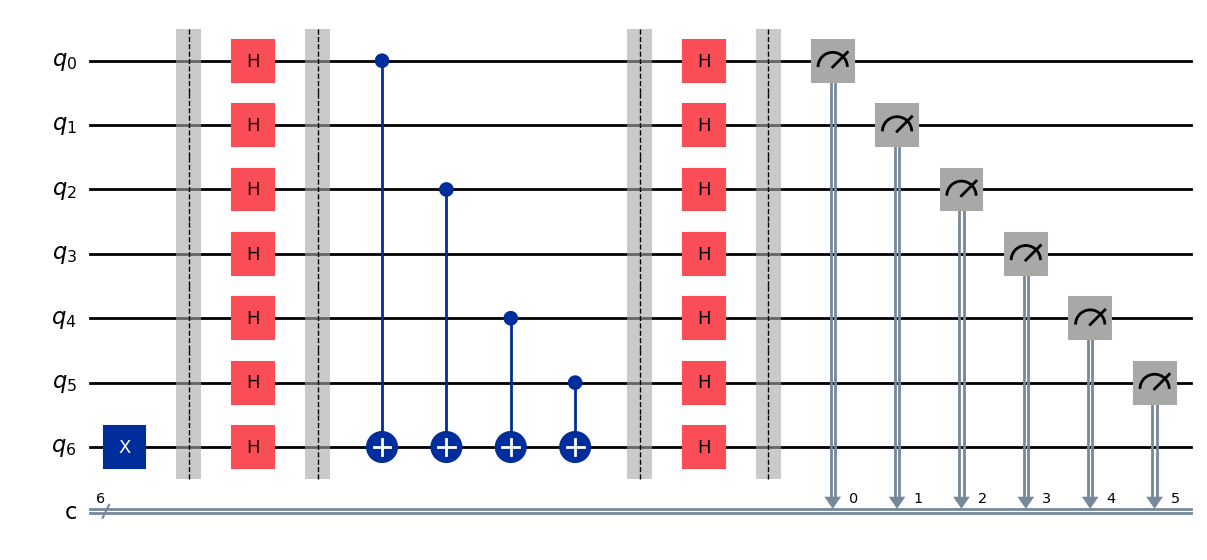

In [8]:
%matplotlib inline
circuit.draw(output='mpl')

# Running the Bernstein-Vazirani algorithm

And finally, let's simulate the circuit on Aer's `qasm_simulator`. We will set the number of shots to 1.

{'110101': 1}


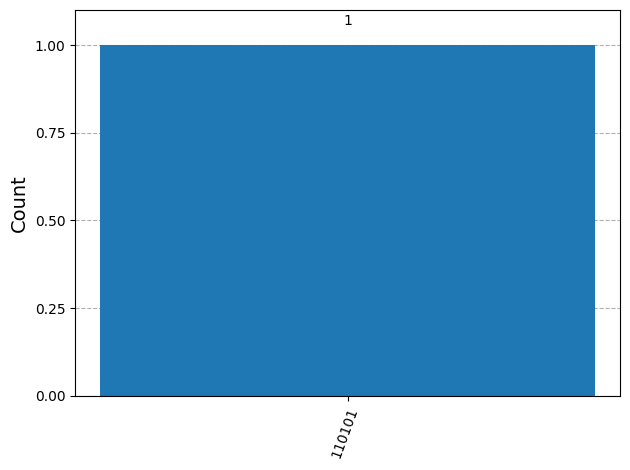

In [9]:
from qiskit_aer import  Aer, QasmSimulator

backend = QasmSimulator()
qc_compiled = transpile(circuit, backend)
job_sim = backend.run(circuit, shots=1)
result = job_sim.result()
counts = result.get_counts(circuit)
print(counts)

from qiskit.visualization import plot_histogram
plot_histogram(result.get_counts(circuit))

In fact, setting the number of shots to 1000, we can still see that 100% of the results contain the secret number.

{'110101': 1000}


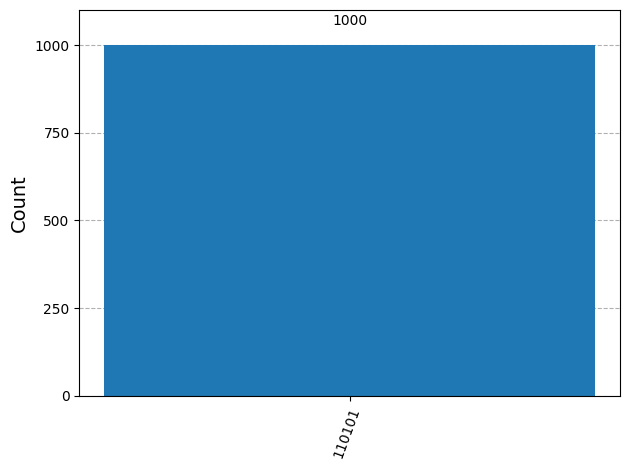

In [10]:
backend = QasmSimulator()
qc_compiled = transpile(circuit, backend)
job_sim = backend.run(circuit, shots=1000)
result = job_sim.result()
counts = result.get_counts(circuit)
print(counts)

from qiskit.visualization import plot_histogram
plot_histogram(result.get_counts(circuit))

# References

#### Journal Papers

1. Ethan Bernstein and Umesh Vazirani (1997) "Quantum Complexity Theory" SIAM Journal on Computing, Vol. 26, No. 5: 1411-1473, <a id='1' href='https://doi.org/10.1137/S0097539796300921'>doi:10.1137/S0097539796300921</a>).

#### Tutorials
For detailed information about Qiskit, check out the tutorials in the Github repository:

https://github.com/Qiskit/qiskit-iqx-tutorials

For a pedagogical presentation of the mathematics behind the Bernstein-Vazirani algorithm, check out our open-source `Learn Quantum Computation using Qiskit` textbook:

https://community.qiskit.org/textbook/

# Version

It's good to note the Qiskit version that was used in your work. One way to do this is print the version at the bottom of the Jupyter notebook using

In [ ]:
qiskit.__qiskit_version__

{'qiskit-terra': '0.9.0',
 'qiskit-ignis': '0.2.0',
 'qiskit-aqua': '0.6.0',
 'qiskit': '0.12.0',
 'qiskit-aer': '0.3.0',
 'qiskit-ibmq-provider': '0.3.2'}

In [ ]:
import qiskit.tools.jupyter
%qiskit_copyright